In [1]:
from __future__ import unicode_literals

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from cycler import cycler
from datetime import date

%matplotlib inline
%config InlineBackend.figure_format='retina'

plt.style.use('/home/hosilva/tools/mplstyle/timesnromanstyle.mplstyle')

In [2]:
import lal, lalsimulation

In [3]:
from tools import find_kde
from tools import combined_posterior

In [4]:
from scipy.interpolate import InterpolatedUnivariateSpline as ius
from scipy.optimize import brentq

In [5]:
# https://computing.docs.ligo.org/daswgweb/docs/technical/LALConstants.pdf
Msun_to_km = 1.476

In [6]:
# Path to events
path_to_GW200129 = "/home/hosilva/parspec/pe/GW200129/"
path_to_GW150914 = "/home/hosilva/parspec/pe/GW150914/"

# Path to samples
path_to_smp = "cbcBayes/posterior_samples.dat"

## 1. dynamical Chern-Simons

In [7]:
data_GW200129_dcs      = np.genfromtxt(path_to_GW200129 + "p4_l_df0_dtau0_CS_220124/" + "cbcBayes/posterior_samples.dat",           names=True, dtype=None)
data_GW200129_spin_dcs = np.genfromtxt(path_to_GW200129 + "p4_l_df0_dtau0_df1_dtau1_CS_220215/" + "cbcBayes/posterior_samples.dat", names=True, dtype=None)

data_GW150914_dcs      = np.genfromtxt(path_to_GW150914 + "parspec_runs/p4_l_df0_dtau0_CS_220203_1052/" + "cbcBayes/posterior_samples.dat",      names=True, dtype=None)
data_GW150914_spin_dcs = np.genfromtxt(path_to_GW150914 + "parspec_runs/p4_l_df0_dtau0_df1_dtau1_CS_220215/" + "cbcBayes/posterior_samples.dat", names=True, dtype=None)

In [8]:
# data_GW200129_dcs.dtype.names

In [9]:
GW200129_dcs_l                   = data_GW200129_dcs['alphangr']
GW200129_dcs_m2s                 = data_GW200129_dcs['m2_source']
GW200129_dcs_mf_source_evol      = data_GW200129_dcs['mf_source_evol']

GW200129_spin_dcs_l              = data_GW200129_spin_dcs['alphangr']
GW200129_spin_dcs_m2s            = data_GW200129_spin_dcs['m2_source']
GW200129_spin_dcs_mf_source_evol = data_GW200129_spin_dcs['mf_source_evol']

In [10]:
GW150914_dcs_l                   = data_GW150914_dcs['alphangr']
GW150914_dcs_m2s                 = data_GW150914_dcs['m2_source']
GW150914_dcs_mf_source_evol      = data_GW150914_dcs['mf_source_evol']

GW150914_spin_dcs_l              = data_GW150914_spin_dcs['alphangr']
GW150914_spin_dcs_m2s            = data_GW150914_spin_dcs['m2_source']
GW150914_spin_dcs_mf_source_evol = data_GW150914_spin_dcs['mf_source_evol']

In [11]:
def find_threshold(mass, thr_coef=1/2.):
    m_in_km = np.median(mass) * Msun_to_km
    return thr_coef * m_in_km

In [12]:
print(
    find_threshold(GW150914_spin_dcs_mf_source_evol), 
    find_threshold(GW200129_spin_dcs_mf_source_evol)
)

45.64202787595715 43.88526652377499


In [13]:
print(
    np.median(GW150914_spin_dcs_mf_source_evol),
    np.median(GW200129_spin_dcs_mf_source_evol))

61.845566227584214 59.465130791023014


In [14]:
print(
    find_threshold(GW150914_spin_dcs_mf_source_evol, 3/10.), 
    find_threshold(GW200129_spin_dpadcs_mf_source_evol, 22/100.)
)

NameError: name 'GW200129_spin_dpadcs_mf_source_evol' is not defined

Combine posteriors in the non-rotating case

/home/abhirup.ghosh/envs/lalsuite_hector_paper_parspec/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


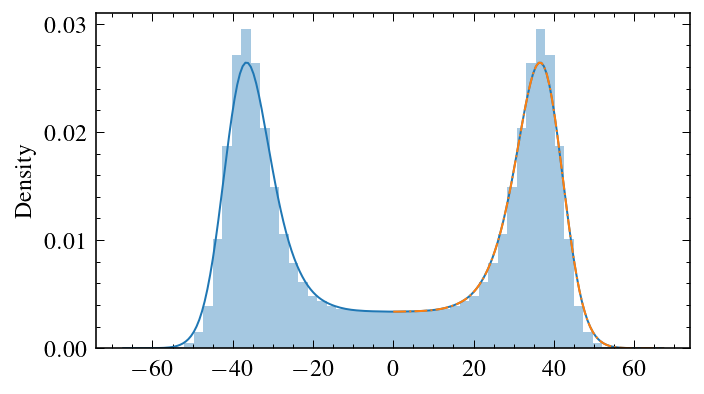

In [15]:
GW150914_dcs_pdf_l_x, GW150914_dcs_pdf_l_y = find_kde(GW150914_dcs_l)

/home/abhirup.ghosh/envs/lalsuite_hector_paper_parspec/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


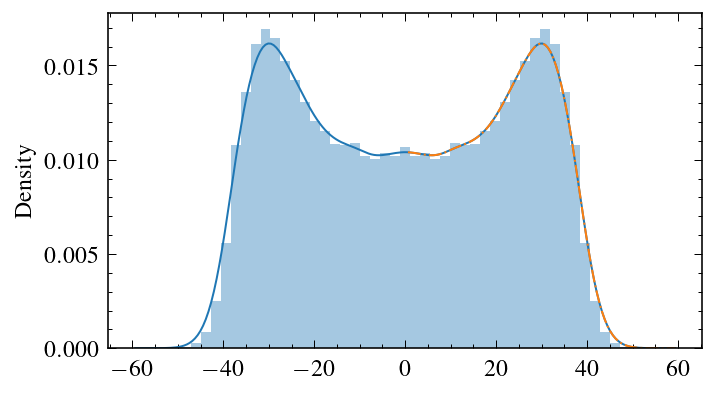

In [16]:
GW200129_dcs_pdf_l_x, GW200129_dcs_pdf_l_y = find_kde(GW200129_dcs_l)

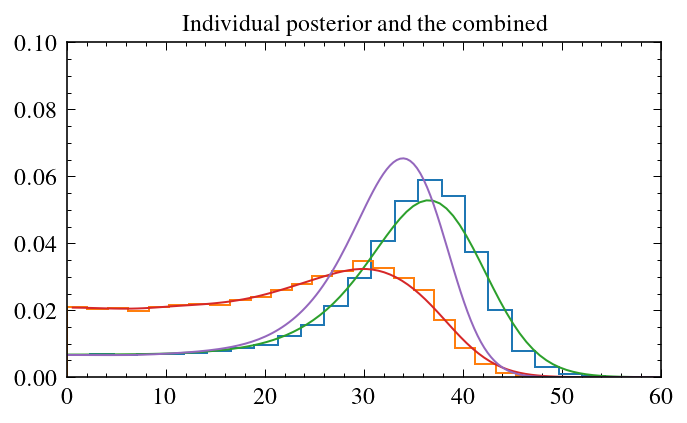

In [17]:
plt.hist(GW150914_dcs_l, density=True, histtype='step', bins=25, ls='-',  label=r"$j=0$");
plt.hist(GW200129_dcs_l, density=True, histtype='step', bins=25, ls='-',  label=r"$j=0$");
plt.plot(GW150914_dcs_pdf_l_x, GW150914_dcs_pdf_l_y)
plt.plot(GW200129_dcs_pdf_l_x, GW200129_dcs_pdf_l_y)

GW150914_dcs_pdf_interp = ius(GW150914_dcs_pdf_l_x, GW150914_dcs_pdf_l_y)
GW200129_dcs_pdf_interp = ius(GW200129_dcs_pdf_l_x, GW200129_dcs_pdf_l_y)

# Now we multiply them:
dcs_l_vals = np.linspace(0, 68, num=201)

dcs_combined_l_vals = [GW150914_dcs_pdf_interp(x) * GW200129_dcs_pdf_interp(x) for x in dcs_l_vals]

dcs_combined_pdf = ius(dcs_l_vals, dcs_combined_l_vals)

dcs_combined_pdf_normalized_vals = np.array(dcs_combined_l_vals) / dcs_combined_pdf.integral(0, 418)

plt.title('Individual posterior and the combined')
plt.plot(dcs_l_vals, dcs_combined_pdf_normalized_vals)

plt.ylim(0, 0.10)
plt.xlim(0, 60);

Combine the posterior in the spin case

/home/abhirup.ghosh/envs/lalsuite_hector_paper_parspec/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


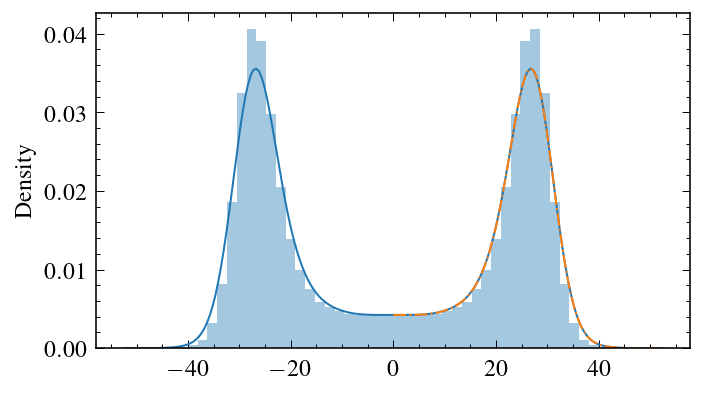

In [18]:
GW150914_spin_dcs_pdf_l_x, GW150914_spin_dcs_pdf_l_y = find_kde(GW150914_spin_dcs_l)

/home/abhirup.ghosh/envs/lalsuite_hector_paper_parspec/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


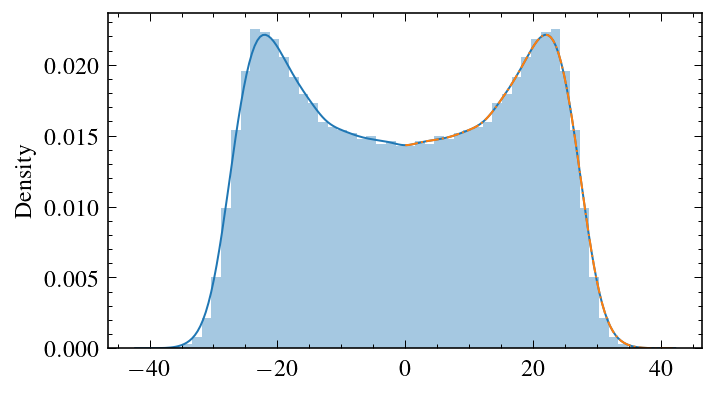

In [19]:
GW200129_spin_dcs_pdf_l_x, GW200129_spin_dcs_pdf_l_y = find_kde(GW200129_spin_dcs_l)

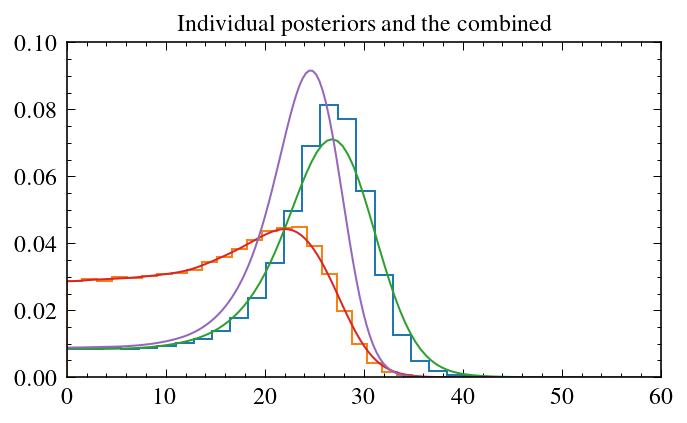

In [20]:
plt.hist(GW150914_spin_dcs_l, density=True, histtype='step', bins=25, ls='-',  label=r"$j=0$");
plt.hist(GW200129_spin_dcs_l, density=True, histtype='step', bins=25, ls='-',  label=r"$j=0$");
plt.plot(GW150914_spin_dcs_pdf_l_x, GW150914_spin_dcs_pdf_l_y)
plt.plot(GW200129_spin_dcs_pdf_l_x, GW200129_spin_dcs_pdf_l_y)

GW150914_spin_dcs_pdf_interp = ius(GW150914_spin_dcs_pdf_l_x, GW150914_spin_dcs_pdf_l_y)
GW200129_spin_dcs_pdf_interp = ius(GW200129_spin_dcs_pdf_l_x, GW200129_spin_dcs_pdf_l_y)

# Now we multiply them:
dcs_spin_l_vals = np.linspace(0, 68, num=201)

dcs_spin_combined_l_vals = [GW150914_spin_dcs_pdf_interp(x) * GW200129_spin_dcs_pdf_interp(x) for x in dcs_spin_l_vals]

dcs_spin_combined_pdf = ius(dcs_spin_l_vals, dcs_spin_combined_l_vals)

dcs_spin_combined_pdf_normalized_vals = np.array(dcs_spin_combined_l_vals) / dcs_spin_combined_pdf.integral(0, 418)

plt.title('Individual posteriors and the combined')
plt.plot(dcs_spin_l_vals, dcs_spin_combined_pdf_normalized_vals)

plt.ylim(0, 0.10);
plt.xlim(0, 60);

Old

/home/abhirup.ghosh/envs/lalsuite_hector_paper_parspec/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/abhirup.ghosh/envs/lalsuite_hector_paper_parspec/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


0.02453157693549937


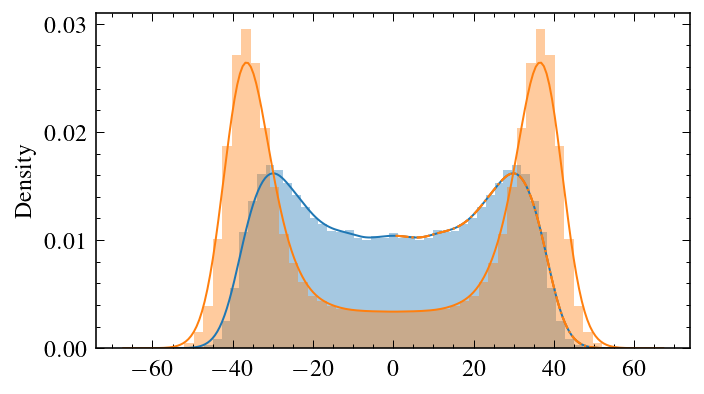

In [21]:
dcs_l_combined, y_dcs_l_combined           = combined_posterior(GW200129_dcs_l,      GW150914_dcs_l)

/home/abhirup.ghosh/envs/lalsuite_hector_paper_parspec/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/abhirup.ghosh/envs/lalsuite_hector_paper_parspec/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


0.03393146030807364


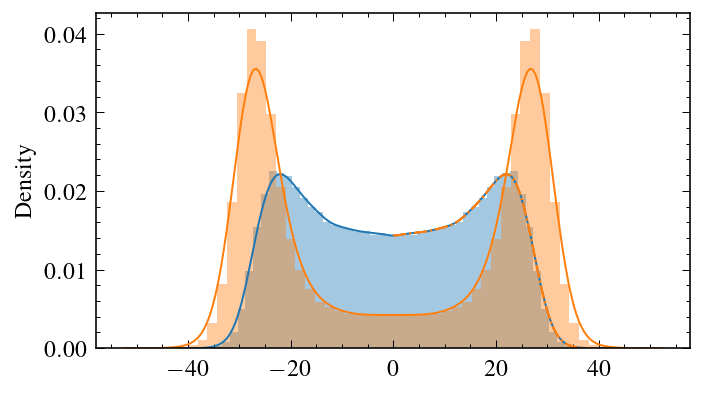

In [22]:
dcs_l_spin_combined, y_dcs_l_spin_combined = combined_posterior(GW200129_spin_dcs_l, GW150914_spin_dcs_l)

In [23]:
from scipy.interpolate import InterpolatedUnivariateSpline as ius
from scipy.optimize import brentq

In [24]:
def find_cdf_at_threshold(m, l, lmax=68):
    # Take the posterior distribution and from seaborn's KDE extract
    # the points from the curve.
    l_tmp, pdf_tmp = find_kde(l)
    
    # Create an interpolating function for the posterior
    pdf_l_tmp = ius(l_tmp, pdf_tmp)
    
    # Calculate CDF at sample values of l by integrating the posterior
    l_vals = np.arange(0, lmax + 1, 1)
    cdf_tmp = [pdf_l_tmp.integral(0, lmax) for lmax in l_vals]
    cdf_l_tmp = ius(l_vals, cdf_tmp)
    
    # Find where it is 90%
    def find_x90(x): return cdf_l_tmp(x) - 0.90
    def find_x68(x): return cdf_l_tmp(x) - 0.68
    x90 = brentq(find_x90, 0, max(l_vals))
    x68 = brentq(find_x68, 0, max(l_vals))
    print(x68, x90, find_threshold(m, 1/2.))
    
    # Set a number of epsilon and calculate the thresholds values
    epsilon_vals  = np.arange(0, 1.0 + 0.01, 0.01)
    m_thresholds  = np.array([find_threshold(m, eps) for eps in epsilon_vals]) # in km

    # Finally, calculate the cdf at the threshold values
    cdf_at_m_thresholds = np.array([cdf_l_tmp(m) for m in m_thresholds])
    
    return epsilon_vals, cdf_at_m_thresholds

/home/abhirup.ghosh/envs/lalsuite_hector_paper_parspec/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


37.45473129729835 42.59044972769536 21.945594300746336


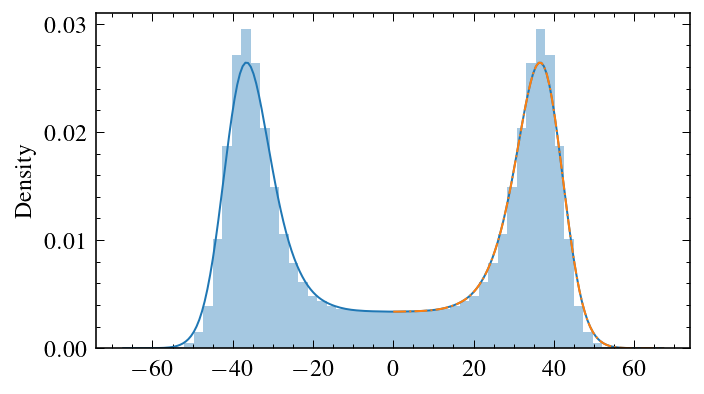

In [25]:
eps_val, GW150914_m2      = find_cdf_at_threshold(GW150914_dcs_m2s,      GW150914_dcs_l)

/home/abhirup.ghosh/envs/lalsuite_hector_paper_parspec/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


27.737011402215277 31.693173410690946 21.95010562860401


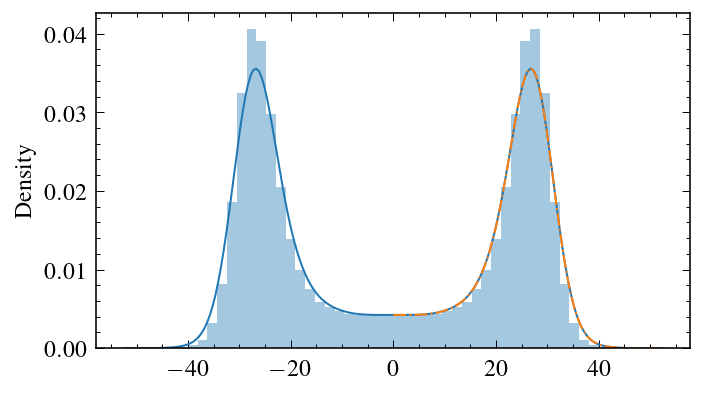

In [26]:
_,       GW150914_m2_spin = find_cdf_at_threshold(GW150914_spin_dcs_m2s, GW150914_spin_dcs_l)

/home/abhirup.ghosh/envs/lalsuite_hector_paper_parspec/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


29.119791184038824 36.63947064496982 21.409608496239574


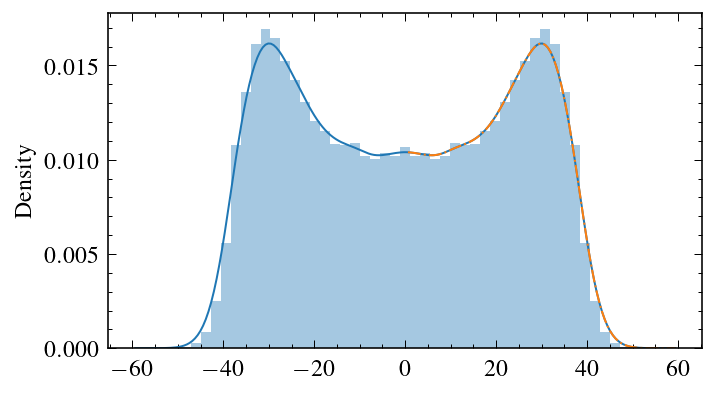

In [27]:
_,       GW200129_m2      = find_cdf_at_threshold(GW200129_dcs_m2s,      GW200129_dcs_l)

/home/abhirup.ghosh/envs/lalsuite_hector_paper_parspec/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


20.67363356423907 25.985611672399155 21.43991861409669


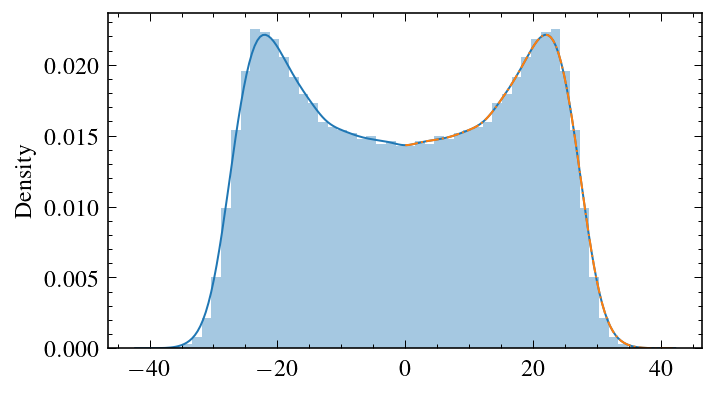

In [28]:
_,       GW200129_m2_spin = find_cdf_at_threshold(GW200129_spin_dcs_m2s, GW200129_spin_dcs_l)

/home/abhirup.ghosh/envs/lalsuite_hector_paper_parspec/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


37.45473129729835 42.59044972769536 45.5430515643193


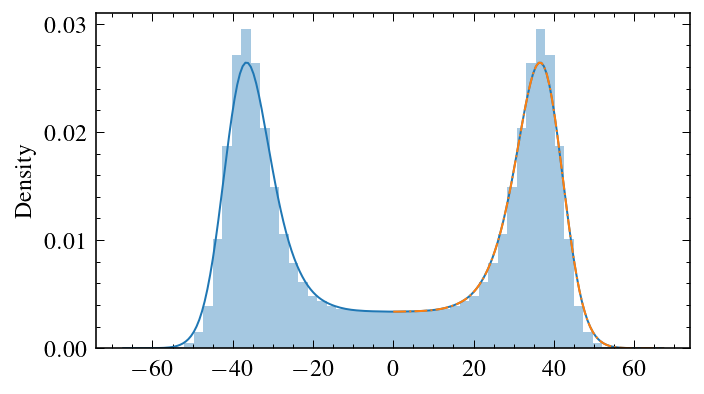

In [29]:
_, GW150914_mf      = find_cdf_at_threshold(GW150914_dcs_mf_source_evol,  GW150914_dcs_l)

/home/abhirup.ghosh/envs/lalsuite_hector_paper_parspec/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


27.737011402215277 31.693173410690946 45.64202787595715


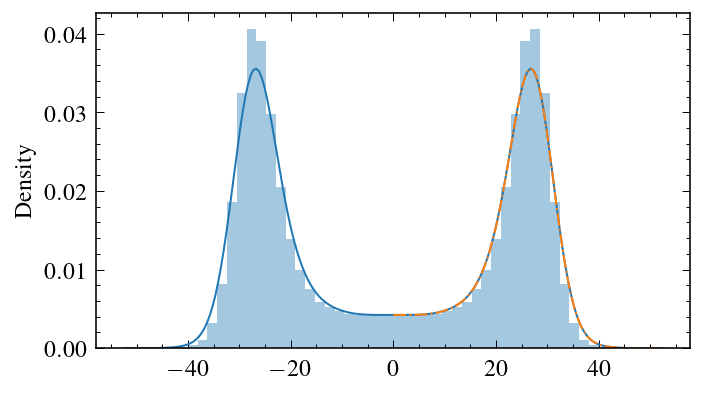

In [30]:
_, GW150914_mf_spin      = find_cdf_at_threshold(GW150914_spin_dcs_mf_source_evol,  GW150914_spin_dcs_l)

/home/abhirup.ghosh/envs/lalsuite_hector_paper_parspec/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


29.119791184038824 36.63947064496982 43.82027561278758


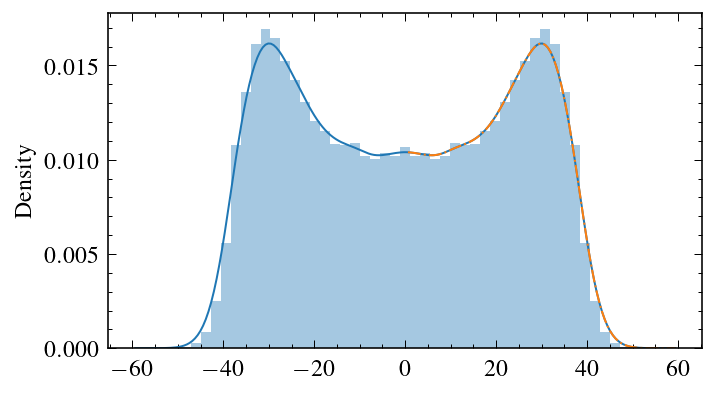

In [31]:
_, GW200129_mf      = find_cdf_at_threshold(GW200129_dcs_mf_source_evol,  GW200129_dcs_l)

/home/abhirup.ghosh/envs/lalsuite_hector_paper_parspec/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


20.67363356423907 25.985611672399155 43.88526652377499


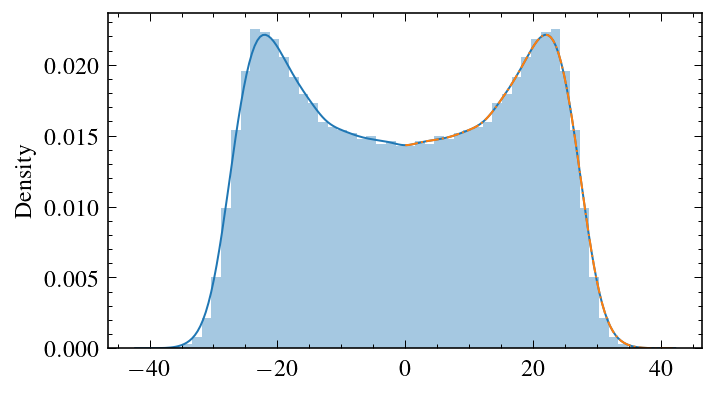

In [32]:
_, GW200129_mf_spin      = find_cdf_at_threshold(GW200129_spin_dcs_mf_source_evol,  GW200129_spin_dcs_l)

/home/abhirup.ghosh/envs/lalsuite_hector_paper_parspec/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


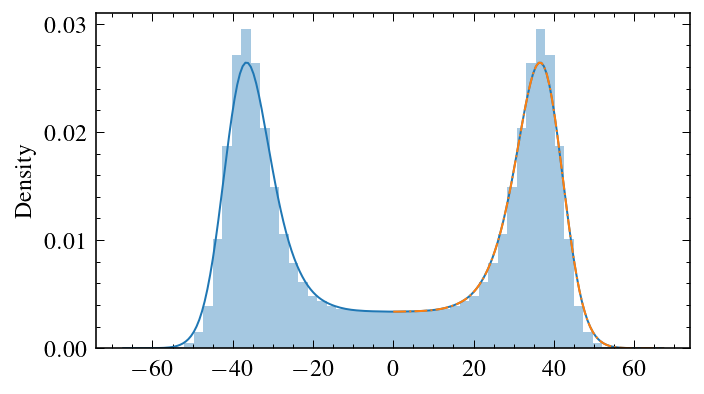

In [33]:
xtmp, ytmp = find_kde(GW150914_dcs_l)
yxtmp = ius(xtmp, ytmp)

In [34]:
xlimit = np.arange(0, 68 + 1, 1)
cdftmp = [yxtmp.integral(0, xmax) for xmax in xlimit]

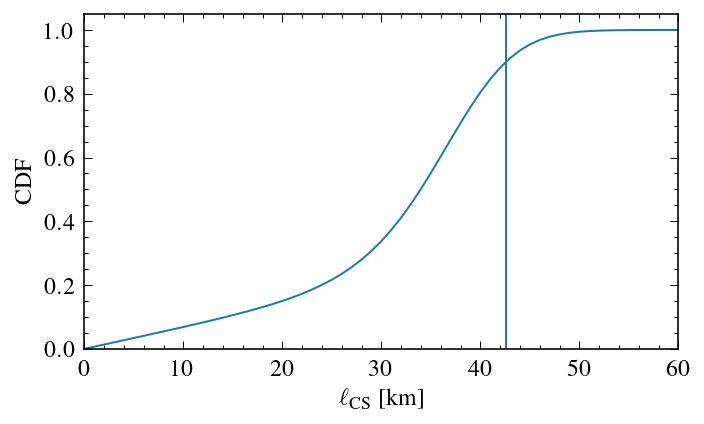

In [35]:
plt.plot(xlimit, cdftmp)
plt.xlim(0, 60)
plt.ylim(0, 1.05)

plt.xlabel(r'$\ell_{\rm CS}$ [km]')
plt.ylabel('CDF')

# Find where the CDF has 90%:
cdfx = ius(xlimit, cdftmp)
def find_x90(x): return cdfx(x) - 0.9

x90  = brentq(find_x90, 40, 50)

plt.axvline(x90)

In [36]:
xcdf = ius(cdftmp, xlimit)

In [37]:
epsilon_vals          = np.arange(0, 1.0 + 0.01, 0.01)

m2s_thresholds        = np.array([find_threshold(GW200129_dcs_m2s, eps) for eps in epsilon_vals]) # in km
cdf_at_m2s_thresholds = np.array([cdfx(m2) for m2 in m2s_thresholds])
l_at_m2s_thresholds   = np.array([xcdf(m2) for m2 in m2s_thresholds])

mf_thresholds         = np.array([find_threshold(GW200129_dcs_mf_source_evol, eps) for eps in epsilon_vals]) # in km
cdf_at_mf_thresholds  = np.array([cdfx(mf) for mf in m2f_thresholds])
l_at_mf_thresholds    = np.array([xcdf(mf) for mf in m2f_thresholds])

NameError: name 'm2f_thresholds' is not defined

/home/abhirup.ghosh/envs/lalsuite_hector_paper_parspec/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  


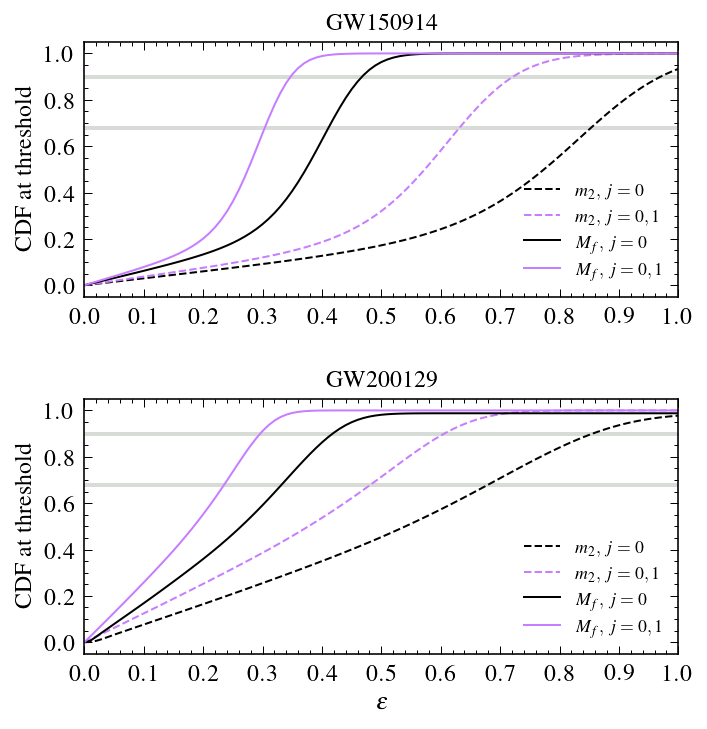

In [38]:
x = [['A', 'A', 'A'],
     ['B', 'B', 'B']]

clist = ["k", "#c77dff"]
lslist = ["dashed", "solid"]

f, axes = plt.subplot_mosaic(mosaic=x, figsize=(5, 5), gridspec_kw={'hspace': 0.4, 'wspace': 0.5, 'bottom': 0.1})
plt.tight_layout()

for k in ('A', 'B'):
    axes[k].set_xlim(0, 1)
    axes[k].set_ylim(-0.05, 1.05)
    axes[k].xaxis.set_ticks(np.arange(0, 1 + 0.1, 0.1))
    axes[k].axhline(0.90, color='xkcd:light gray', lw=2)
    axes[k].axhline(0.68, color='xkcd:light gray', lw=2)

# -------
# Panel A
# -------
axes['A'].plot(eps_val, GW150914_m2,      color=clist[0], ls=lslist[0], label=r"$m_{2}, \, j=0$")
axes['A'].plot(eps_val, GW150914_m2_spin, color=clist[1], ls=lslist[0], label=r"$m_{2}, \, j=0,1$")
axes['A'].plot(eps_val, GW150914_mf,      color=clist[0], ls=lslist[1], label=r"$M_{f}, \, j=0$")
axes['A'].plot(eps_val, GW150914_mf_spin, color=clist[1], ls=lslist[1], label=r"$M_{f}, \, j=0,1$")
axes['A'].set_ylabel('CDF at threshold')
axes['A'].set_title("GW150914");
axes['A'].legend(loc='lower right', frameon=False, fontsize=9, facecolor='white', edgecolor='white');
axes['A'].yaxis.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1.0]);

# -------
# Panel B
# -------
axes['B'].plot(eps_val, GW200129_m2,      color=clist[0], ls=lslist[0],  label=r"$m_{2}, \, j=0$")
axes['B'].plot(eps_val, GW200129_m2_spin, color=clist[1], ls=lslist[0], label=r"$m_{2}, \, j=0,1$")
axes['B'].plot(eps_val, GW200129_mf,      color=clist[0], ls=lslist[1], label=r"$M_{f}, \, j=0$")
axes['B'].plot(eps_val, GW200129_mf_spin, color=clist[1], ls=lslist[1],  label=r"$M_{f}, \, j=0,1$")
axes['B'].set_ylabel('CDF at threshold')
axes['B'].set_xlabel(r'$\varepsilon$')
axes['B'].set_title("GW200129");
axes['B'].legend(loc='lower right', fontsize=9);
axes['B'].yaxis.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1.0]);

plt.savefig('fig_output/dcs_cdf_varying_threshold.pdf')

In [39]:
delta_omega0 = 3.1964
delta_omega1 = 41.199
delta_tau0   = 6.3619
delta_tau1   = 794.66

def l_over_mf(mf, l, p):
    mf_in_km = mf * Msun_to_km
    return (l / mf_in_km)**p

(array([3.7704e+04, 2.9210e+04, 3.1826e+04, 2.2519e+04, 1.0119e+04,
        2.8900e+03, 7.2000e+02, 1.6500e+02, 3.3000e+01, 2.0000e+00]),
 array([7.62637349e-22, 3.19641367e-02, 6.39282735e-02, 9.58924102e-02,
        1.27856547e-01, 1.59820684e-01, 1.91784820e-01, 2.23748957e-01,
        2.55713094e-01, 2.87677231e-01, 3.19641367e-01]),
 <BarContainer object of 10 artists>)

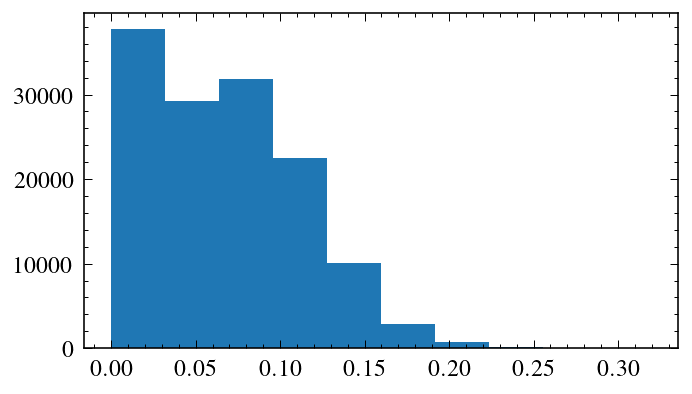

In [40]:
plt.hist(delta_omega0 * l_over_mf(GW150914_dcs_mf_source_evol, GW150914_dcs_l, 4))

(0.0, 1.0)

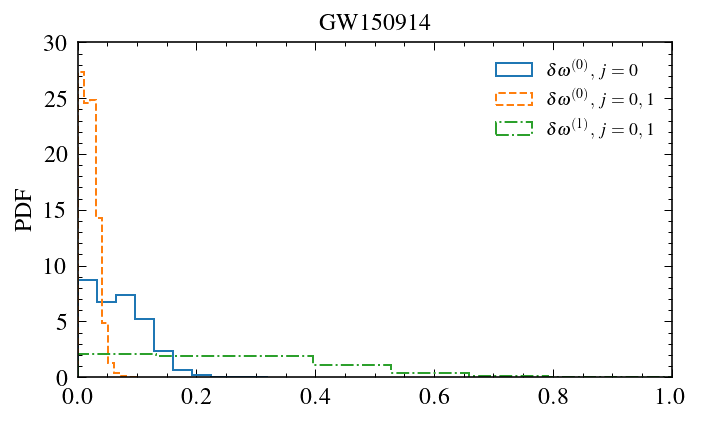

In [41]:
plt.hist(delta_omega0 * l_over_mf(GW150914_dcs_mf_source_evol,      GW150914_dcs_l, 4),      density=True, histtype='step', ls='-',   label=r"$\delta \omega^{(0)},\, j=0$")
plt.hist(delta_omega0 * l_over_mf(GW150914_spin_dcs_mf_source_evol, GW150914_spin_dcs_l, 4), density=True, histtype='step', ls='--',  label=r"$\delta \omega^{(0)},\, j=0, \, 1$")
plt.hist(delta_omega1 * l_over_mf(GW150914_spin_dcs_mf_source_evol, GW150914_spin_dcs_l, 4), density=True, histtype='step', ls='-.',  label=r"$\delta \omega^{(1)},\, j=0, \, 1$")
plt.ylabel('PDF')
plt.title("GW150914");
plt.legend(loc='upper right', frameon=True, fontsize=9, facecolor='white', edgecolor='white');
# axes['A'].set_xlabel(r'$\delta \omega^{(j)} [c^2 \ell_{\rm CS} / (G M_f)]^{4}$')
plt.ylim(0, 30)
plt.xlim(0, 1)

(0.0, 1.0)

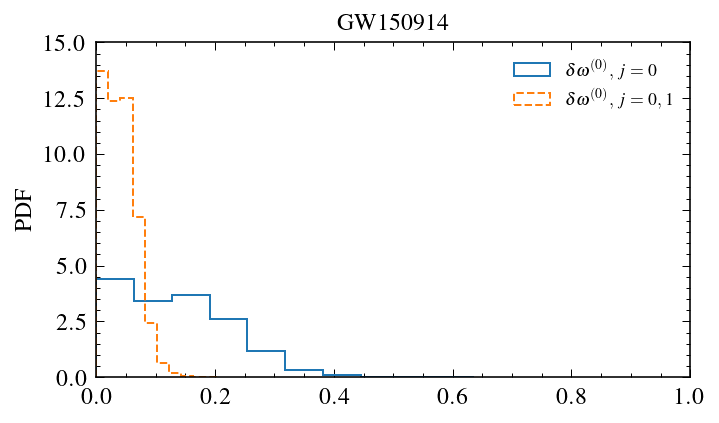

In [42]:
plt.hist(delta_tau0 * l_over_mf(GW150914_dcs_mf_source_evol,      GW150914_dcs_l, 4),      density=True, histtype='step', ls='-',   label=r"$\delta \omega^{(0)},\, j=0$")
plt.hist(delta_tau0 * l_over_mf(GW150914_spin_dcs_mf_source_evol, GW150914_spin_dcs_l, 4), density=True, histtype='step', ls='--',  label=r"$\delta \omega^{(0)},\, j=0, \, 1$")
plt.ylabel('PDF')
plt.title("GW150914");
plt.legend(loc='upper right', frameon=True, fontsize=9, facecolor='white', edgecolor='white');
# axes['A'].set_xlabel(r'$\delta \omega^{(j)} [c^2 \ell_{\rm CS} / (G M_f)]^{4}$')
plt.ylim(0, 15)
plt.xlim(0, 1)

(0.0, 30.0)

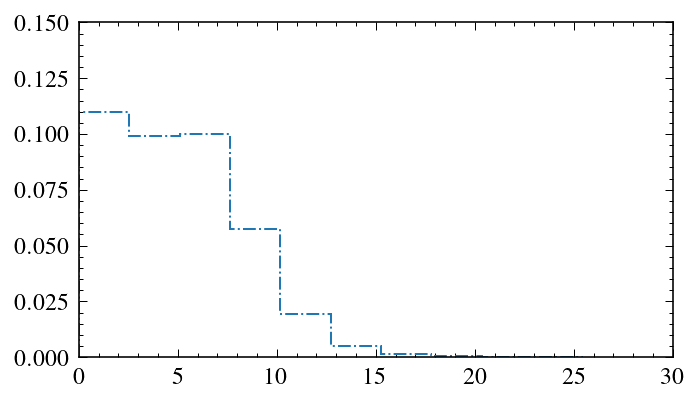

In [43]:
# Warning! This means that we cannot use GW150914 with spin corrections!
plt.hist(delta_tau1 * l_over_mf(GW150914_spin_dcs_mf_source_evol, GW150914_spin_dcs_l, 4), density=True, histtype='step', ls='-.',  label=r"$\delta \omega^{(1)},\, j=0, \, 1$")
plt.ylim(0, 0.15)
plt.xlim(0, 30)

/home/abhirup.ghosh/envs/lalsuite_hector_paper_parspec/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  """


(0.0, 1.0)

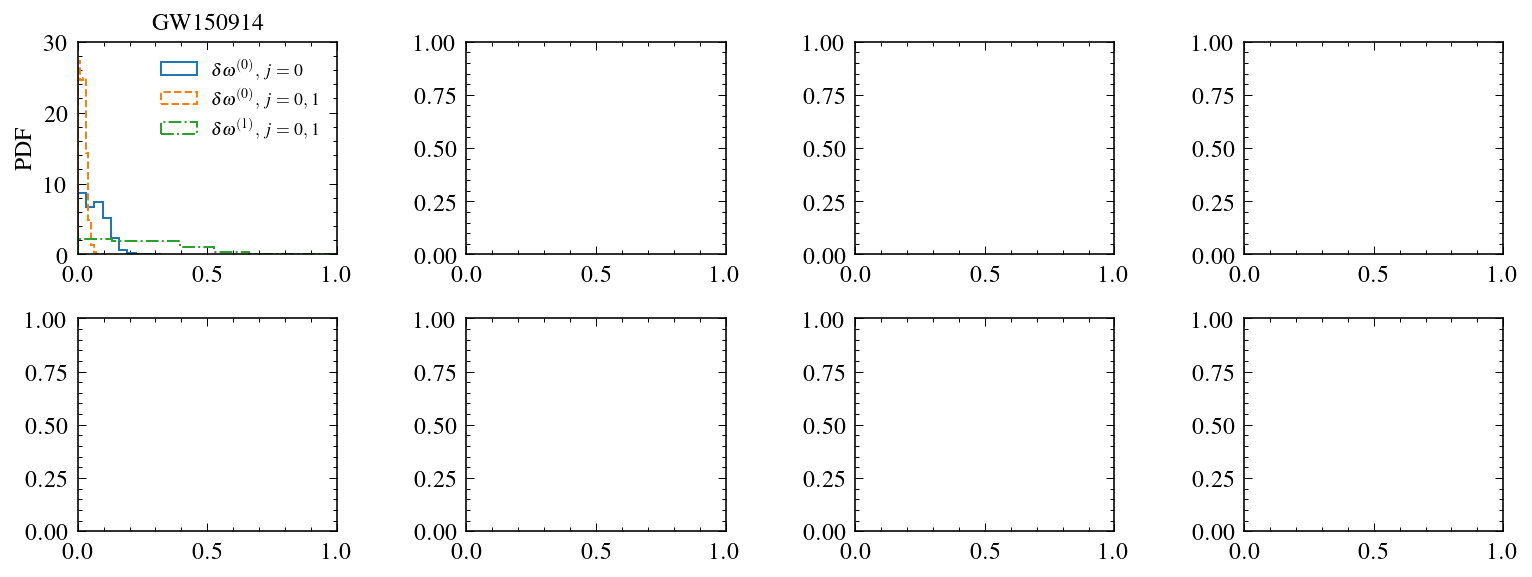

In [44]:
x = [['A', 'B', 'C', 'D'],
     ['E', 'F', 'G', 'H']]

f, axes = plt.subplot_mosaic(mosaic=x, figsize=(12, 4), gridspec_kw={'hspace': 0.3, 'wspace': 0.5, 'bottom': 0.1})
plt.tight_layout()

# -------
# Panel A
# -------
axes['A'].hist(delta_omega0 * l_over_mf(GW150914_dcs_mf_source_evol,      GW150914_dcs_l, 4),      density=True, histtype='step', ls='-',   label=r"$\delta \omega^{(0)},\, j=0$")
axes['A'].hist(delta_omega0 * l_over_mf(GW150914_spin_dcs_mf_source_evol, GW150914_spin_dcs_l, 4), density=True, histtype='step', ls='--',  label=r"$\delta \omega^{(0)},\, j=0, \, 1$")
axes['A'].hist(delta_omega1 * l_over_mf(GW150914_spin_dcs_mf_source_evol, GW150914_spin_dcs_l, 4), density=True, histtype='step', ls='-.',  label=r"$\delta \omega^{(1)},\, j=0, \, 1$")
axes['A'].set_ylabel('PDF')
axes['A'].set_title("GW150914");
axes['A'].legend(loc='upper right', frameon=True, fontsize=9, facecolor='white', edgecolor='white');
# axes['A'].set_xlabel(r'$\delta \omega^{(j)} [c^2 \ell_{\rm CS} / (G M_f)]^{4}$')
axes['A'].set_ylim(0, 30)
axes['A'].set_xlim(0, 1)

# -------
# Panel B
# -------



# for k in ('A', 'B', 'C', 'D'):
#     axes[k].set_xlim(0, 10)
#     # axes[k].xaxis.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1.0]);
    
# for k in ('A', 'B'): 
#     axes[k].set_xticklabels([]);
#     axes[k].set_title("GW150914");
    
# for k in ('C', 'D'): 
#     axes[k].set_title("GW200129");

# for k in ('C'): 
#     axes[k].set_xlabel(r'$\delta \omega^{(j)} [c^2 \ell_{\rm CS} / (G M_f)]^{4}$')
    
# for k in ('D'): 
#     axes[k].set_xlabel(r'$\delta \tau^{(j)} [c^2 \ell_{\rm CS} / (G M_f)]^{4}$')

# # -------
# # Panel A
# # -------
# # axes['A'].hist(eps_val, GW150914_m2,      'C0-',  label=r"$m_{2}, \, j=0$")
# # axes['A'].plot(eps_val, GW150914_m2_spin, 'C0--', label=r"$m_{2}, \, j=0,1$")
# # axes['A'].plot(eps_val, GW150914_mf,      'C1-.', label=r"$M_{f}, \, j=0$")
# # axes['A'].plot(eps_val, GW150914_mf_spin, 'C1:',  label=r"$M_{f}, \, j=0,1$")
# axes['A'].hist(delta_omega0 * l_over_mf(GW150914_dcs_mf_source_evol,      GW150914_dcs_l, 4),      density=True, histtype='step', ls='-',   label=r"$\delta \omega^{(0)},\, j=0$")
# axes['A'].hist(delta_omega0 * l_over_mf(GW150914_spin_dcs_mf_source_evol, GW150914_spin_dcs_l, 4), density=True, histtype='step', ls='--',  label=r"$\delta \omega^{(0)},\, j=0, \, 1$")
# axes['A'].hist(delta_omega1 * l_over_mf(GW150914_spin_dcs_mf_source_evol, GW150914_spin_dcs_l, 4), density=True, histtype='step', ls='-.',  label=r"$\delta \omega^{(1)},\, j=0, \, 1$")
# axes['A'].set_ylabel('PDF')
# axes['A'].set_title("GW150914");
# axes['A'].legend(loc='upper right', frameon=True, fontsize=9, facecolor='white', edgecolor='white');
# axes['A'].set_xlabel(r'$\delta \omega^{(j)} [c^2 \ell_{\rm CS} / (G M_f)]^{4}$')
# # axes['A'].yaxis.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1.0]);
# axes['A'].set_ylim(0, 30)

# # -------
# # Panel B
# # -------
# # axes['B'].hist(delta_tau0 * l_over_mf(GW150914_dcs_mf_source_evol,      GW150914_dcs_l, 4),      density=True, histtype='step', ls='-',   label=r"$\delta \tau^{(0)},\, j=0$")
# # axes['B'].hist(delta_tau0 * l_over_mf(GW150914_spin_dcs_mf_source_evol, GW150914_spin_dcs_l, 4), density=True, histtype='step', ls='--',  label=r"$\delta \tau^{(0)},\, j=0, \, 1$")
# axes['B'].hist(delta_tau1 * l_over_mf(GW150914_spin_dcs_mf_source_evol, GW150914_spin_dcs_l, 4), density=True, histtype='step', ls='-.',  label=r"$\delta \tau^{(1)},\, j=0, \, 1$")
# axes['B'].legend(loc='upper right', fontsize=9);

# # -------
# # Panel C
# # -------
# axes['C'].set_ylabel('PDF')
# axes['C'].legend(loc='upper right', fontsize=9);

# plt.savefig('fig_output/gammaomega_plots.pdf')

/home/abhirup.ghosh/envs/lalsuite_hector_paper_parspec/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  if __name__ == '__main__':
/home/abhirup.ghosh/envs/lalsuite_hector_paper_parspec/lib/python3.7/site-packages/pesummary/utils/decorators.py:276: UserWarning: The Bounded_1d_kde class has changed its name to ReflectionBoundedKDE. Bounded_1d_kde may not be supported in future releases. Please update.
  warnings.warn(warning)
/home/abhirup.ghosh/envs/lalsuite_hector_paper_parspec/lib/python3.7/site-packages/pesummary/utils/decorators.py:276: UserWarning: The Bounded_1d_kde class has changed its name to ReflectionBoundedKDE. Bounded_1d_kde may not be supported in future releases. Please update.
  warnings.warn(warning)
/home/abhirup.ghosh/envs/lalsuite_hector_paper_parspec/lib/python3.7/site-packages/pesummary/utils/decorators.py:276: UserWarning: The Bounded_1d_kde clas

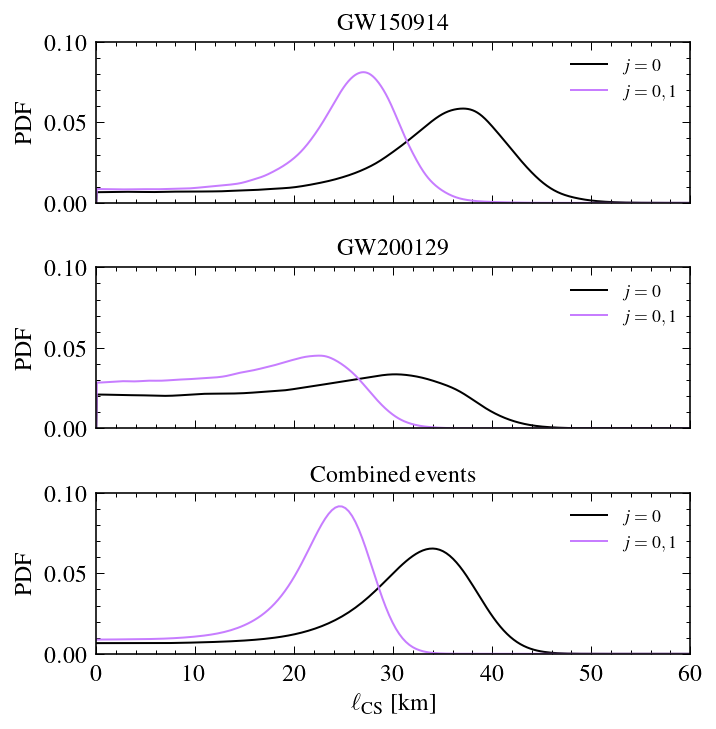

In [57]:
from pesummary.core.plots.bounded_1d_kde import Bounded_1d_kde
l_bins=np.linspace(0,60,1000)

x = [['A', 'A', 'A'],
     ['B', 'B', 'B'],
     ['C', 'C', 'C']]

f, axes = plt.subplot_mosaic(mosaic=x, figsize=(5, 5), gridspec_kw={'hspace': 0.4, 'wspace': 0.6, 'bottom':0.1})
plt.tight_layout()

clist = ["k", "#c77dff"]

for k in ('A', 'B', 'C'):
    axes[k].set_xlim(0, 60)
    axes[k].xaxis.set_ticks(np.arange(0, 60+10, 10))
    
for k in ('A', 'B'):
    axes[k].set_xticklabels([]);
    
axes['C'].set_xlabel(r'$\ell_{\rm CS}$ [km]');

#axes['A'].hist(GW150914_dcs_l,      density=True, histtype='step', bins=25, ls='-',  label=r"$j=0$");
#axes['A'].hist(GW150914_spin_dcs_l, density=True, histtype='step', bins=25, ls='--', label=r"$j=0,1$");

kde=Bounded_1d_kde(GW150914_dcs_l,xlow=min(GW150914_dcs_l))
axes['A'].plot(l_bins,kde(l_bins),color=clist[0],label=r"$j=0$")

kde=Bounded_1d_kde(GW150914_spin_dcs_l,xlow=min(GW150914_spin_dcs_l))
axes['A'].plot(l_bins,kde(l_bins),color=clist[1],label=r"$j=0,1$")

axes['A'].set_ylim(0, 0.10);
axes['A'].yaxis.set_ticks([0, 0.05, 0.10]);
axes['A'].set_title("GW150914");
axes['A'].legend(loc='upper right', fontsize=9);
axes['A'].set_ylabel("PDF");

#axes['B'].hist(GW200129_dcs_l,      density=True, histtype='step', bins=25, ls='-',  label=r"$j=0$");
#axes['B'].hist(GW200129_spin_dcs_l, density=True, histtype='step', bins=25, ls='--', label=r"$j=0,1$");

kde=Bounded_1d_kde(GW200129_dcs_l,xlow=min(GW200129_dcs_l))
axes['B'].plot(l_bins,kde(l_bins),color=clist[0],label=r"$j=0$")

kde=Bounded_1d_kde(GW200129_spin_dcs_l,xlow=min(GW200129_spin_dcs_l))
axes['B'].plot(l_bins,kde(l_bins),color=clist[1],label=r"$j=0,1$")

axes['B'].set_ylim(0, 0.10);
axes['B'].yaxis.set_ticks([0, 0.05, 0.10]);
axes['B'].set_title("GW200129");
axes['B'].legend(loc='upper right', fontsize=9);
axes['B'].set_ylabel("PDF");

axes['C'].set_title("Combined events");
axes['C'].xaxis.set_ticks(np.arange(0, 60+10, 10))
axes['C'].set_ylabel("PDF");
# axes['C'].plot(dcs_l_combined, y_dcs_l_combined, '-',  label=r"$j=0$")
# axes['C'].plot(dcs_l_spin_combined, y_dcs_l_spin_combined, '--', label=r"$j=0,1$")
axes['C'].plot(dcs_l_vals, dcs_combined_pdf_normalized_vals, color=clist[0],  label=r"$j=0$")
axes['C'].plot(dcs_spin_l_vals, dcs_spin_combined_pdf_normalized_vals, color=clist[1], label=r"$j=0,1$")
axes['C'].legend(loc='upper right', fontsize=9);
axes['C'].set_ylim(0, 0.10);
axes['C'].yaxis.set_ticks([0, 0.05, 0.10]);

plt.savefig('fig_output/dcs_posteriors_combined.pdf')

In [46]:
pdf_l_combined = ius(dcs_l_combined, y_dcs_l_combined)

xlimit = np.arange(0, 68 + 1, 1)
cdf_l_list = [pdf_l_combined.integral(0, xmax) for xmax in xlimit]

cdf_l_combined = ius(xlimit, cdf_l_list)

def find_x90(x): return cdf_l_combined(x) - 0.9

print(brentq(find_x90, 20, 40))

34.5542767955896


/home/abhirup.ghosh/envs/lalsuite_hector_paper_parspec/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  


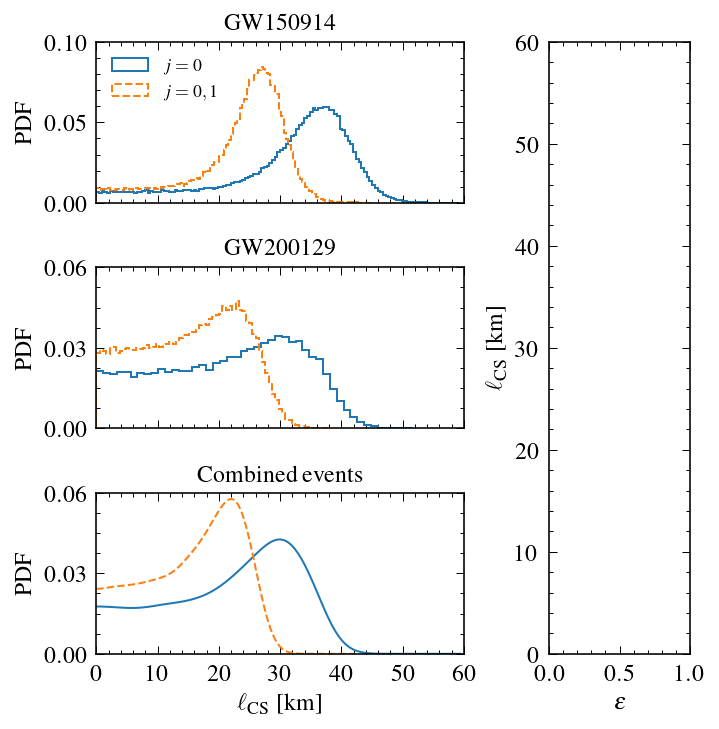

In [47]:
x = [['A', 'A', 'D'],
     ['B', 'B', 'D'],
     ['C', 'C', 'D']]

f, axes = plt.subplot_mosaic(mosaic=x, figsize=(5, 5), gridspec_kw={'hspace': 0.4, 'wspace': 0.6, 'bottom': 0.1})
plt.tight_layout()

for k in ('A', 'B', 'C'):
    axes[k].set_xlim(0, 60)
    axes[k].xaxis.set_ticks(np.arange(0, 60+10, 10))
    
for k in ('A', 'B'):
    axes[k].set_xticklabels([]);
    
axes['C'].set_xlabel(r'$\ell_{\rm CS}$ [km]');

axes['A'].hist(GW150914_dcs_l,      density=True, histtype='step', bins='fd', ls='-',  label=r"$j=0$");
axes['A'].hist(GW150914_spin_dcs_l, density=True, histtype='step', bins='fd', ls='--', label=r"$j=0,1$");
axes['A'].set_ylim(0, 0.10);
axes['A'].yaxis.set_ticks([0, 0.05, 0.10]);
axes['A'].set_title("GW150914");
axes['A'].legend(loc='upper left', fontsize=9);
axes['A'].set_ylabel("PDF");

axes['B'].hist(GW200129_dcs_l,      density=True, histtype='step', bins='fd', ls='-',  label=r"$j=0$");
axes['B'].hist(GW200129_spin_dcs_l, density=True, histtype='step', bins='fd', ls='--', label=r"$j=0,1$");
axes['B'].set_ylim(0, 0.06);
axes['B'].yaxis.set_ticks([0, 0.03, 0.06]);
axes['B'].set_title("GW200129");
axes['B'].set_ylabel("PDF");

axes['C'].set_title("Combined events");
axes['C'].xaxis.set_ticks(np.arange(0, 60+10, 10))
axes['C'].set_ylabel("PDF");
axes['C'].plot(dcs_l_combined, y_dcs_l_combined, '-')
axes['C'].plot(dcs_l_spin_combined, y_dcs_l_spin_combined, '--')
axes['C'].set_ylim(0, 0.06)
axes['C'].yaxis.set_ticks([0, 0.03, 0.06]);

axes['D'].set_xlim(0, 1)
axes['D'].set_ylim(0, 60)
axes['D'].xaxis.set_ticks([0, 0.5, 1.0]);
axes['D'].set_xlabel(r'$\varepsilon$');
axes['D'].set_ylabel(r'$\ell_{\rm CS}$ [km]');

# plt.savefig('fig_output/dcs_posteriors.pdf')

In [48]:
dcs_l_combined

array([ 0.        ,  0.5995382 ,  1.19907641,  1.79861461,  2.39815282,
        2.99769102,  3.59722923,  4.19676743,  4.79630563,  5.39584384,
        5.99538204,  6.59492025,  7.19445845,  7.79399665,  8.39353486,
        8.99307306,  9.59261127, 10.19214947, 10.79168768, 11.39122588,
       11.99076408, 12.59030229, 13.18984049, 13.7893787 , 14.3889169 ,
       14.98845511, 15.58799331, 16.18753151, 16.78706972, 17.38660792,
       17.98614613, 18.58568433, 19.18522253, 19.78476074, 20.38429894,
       20.98383715, 21.58337535, 22.18291356, 22.78245176, 23.38198996,
       23.98152817, 24.58106637, 25.18060458, 25.78014278, 26.37968098,
       26.97921919, 27.57875739, 28.1782956 , 28.7778338 , 29.37737201,
       29.97691021, 30.57644841, 31.17598662, 31.77552482, 32.37506303,
       32.97460123, 33.57413944, 34.17367764, 34.77321584, 35.37275405,
       35.97229225, 36.57183046, 37.17136866, 37.77090686, 38.37044507,
       38.96998327, 39.56952148, 40.16905968, 40.76859789, 41.36

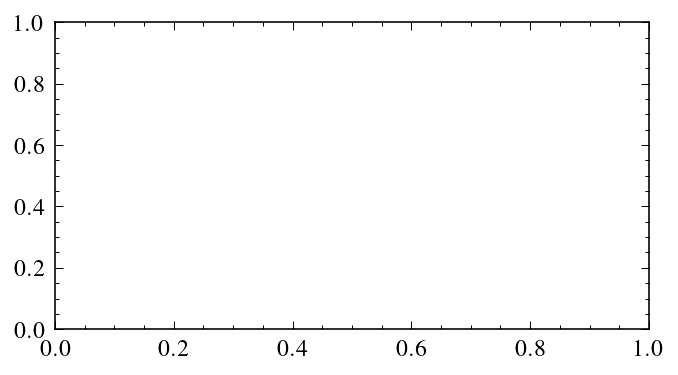

In [49]:
f, ax = plt.subplots(1, 1, figsize=(5, 2.75))

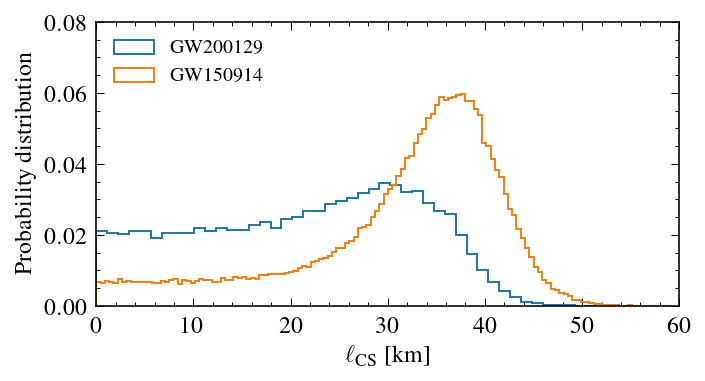

In [50]:
f, ax = plt.subplots(1, 1, figsize=(5, 2.75))

ax.hist(GW200129_dcs_l, density=True, histtype='step', bins='fd',
        label="GW200129")
ax.hist(GW150914_dcs_l, density=True, histtype='step', bins='fd',
        label="GW150914")

thr_m2s  = find_threshold(GW200129_dcs_m2s)
thr_mfs  = find_threshold(GW200129_dcs_mf_source_evol)

# ax.axvline(thr_m2s, c='C0', ls="--",  lw=.8)
# ax.axvline(thr_mfs, c='C0', ls="-.",  lw=.8)

# ax.text(thr_m2s - 3, 0.035, r"$m_2$",   rotation=90)
# ax.text(thr_mfs - 3, 0.035, r"$M_{f}$", rotation=90)

ax.set_xlim(0, 60)
ax.set_ylim(0, 0.08)

ax.set_ylabel('Probability distribution')
ax.set_xlabel(r'$\ell_{\rm CS}$ [km]')

ax.legend(loc='upper left')

plt.tight_layout()
plt.savefig("fig_output/dcs_GW200129_GW150914.pdf")

In [51]:
delta_omega0 = 3.1964
delta_omega1 = 41.199

def l_over_mf(mf, l, p):
    mf_in_km = mf * Msun_to_km
    return (l / mf_in_km)**p

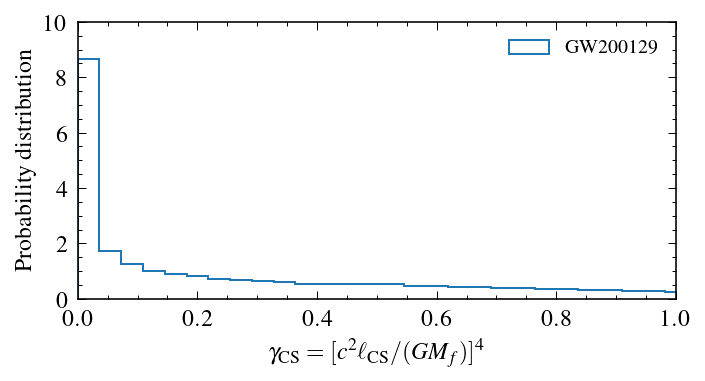

In [152]:
f, ax = plt.subplots(1, 1, figsize=(5, 2.75))

GW200129_l_over_mf = l_over_mf(GW200129_dcs_mf_source_evol, GW200129_dcs_l, p=4)

ax.hist(delta_omega1 * GW200129_l_over_mf, density=True, histtype='step', bins='fd',
        label="GW200129")

thr_m2s  = find_threshold(GW200129_dcs_m2s)
thr_mfs  = find_threshold(GW200129_dcs_mf_source_evol)

# ax.axvline(thr_m2s, c='C0', ls="--",  lw=.8)
# ax.axvline(thr_mfs, c='C0', ls="-.",  lw=.8)

# ax.text(thr_m2s - 3, 0.035, r"$m_2$",   rotation=90)
# ax.text(thr_mfs - 3, 0.035, r"$M_{f}$", rotation=90)

ax.set_xlim(0, 1)
ax.set_ylim(0, 10)

ax.set_ylabel('Probability distribution')
ax.set_xlabel(r'$\gamma_{\rm CS} = [c^2 \ell_{\rm CS} / (G M_f)]^{4}$')

ax.legend()

plt.tight_layout()
# plt.savefig("fig_output/dcs_gamma_GW200129.pdf")

In [21]:
!scp -r hosilva@hypatia2.aei.mpg.de:/home/hosilva/parspec/jnb/pe/production_plots/fig_output /Users/hectorokadadasilva

/Users/hectorokadadasilva: No such file or directory


In [42]:
np.median(GW200129_dcs_m2s)

28.814677483182113

In [52]:
np.median(GW200129_dcs_mf_source_evol)

26.959635354690132

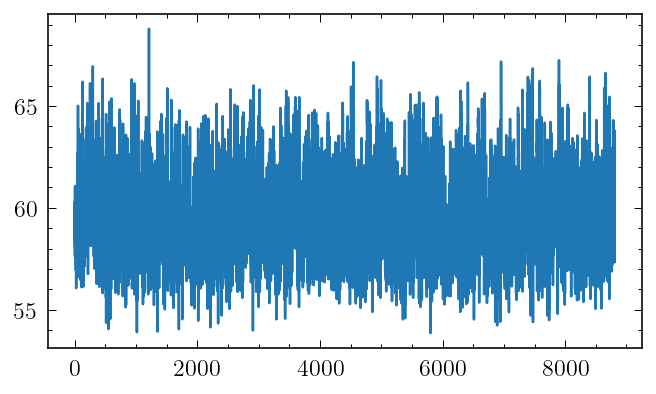

In [14]:
plt.plot(GW200129_dcs_mf_source_evol)

## 2. shift-symmetric scalar-Gauss-Bonnet

/local/tmp/hosilva/ipykernel_723963/4019734904.py:6: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


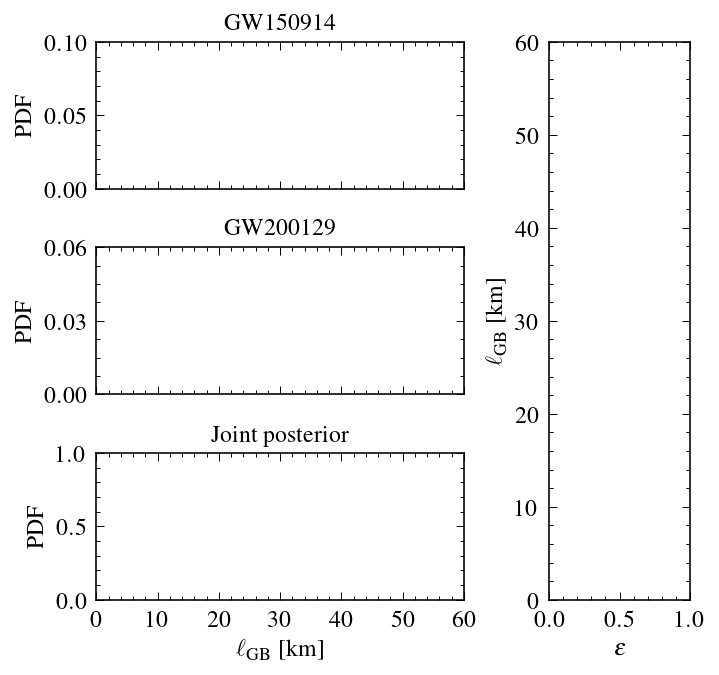

In [5]:
x = [['A', 'A', 'D'],
     ['B', 'B', 'D'],
     ['C', 'C', 'D']]

f, axes = plt.subplot_mosaic(mosaic=x, figsize=(5, 5), gridspec_kw={'hspace': 0.4, 'wspace': 0.6})
plt.tight_layout()

for k in ('A', 'B', 'C'):
    axes[k].set_xlim(0, 60)
    axes[k].xaxis.set_ticks(np.arange(0, 60+10, 10))
    
for k in ('A', 'B'):
    axes[k].set_xticklabels([]);
    
axes['C'].set_xlabel(r'$\ell_{\rm GB}$ [km]');

# axes['A'].hist(GW150914_dcs_l,      density=True, histtype='step', bins='fd', label=r"$j=0$");
# axes['A'].hist(GW150914_spin_dcs_l, density=True, histtype='step', bins='fd', label=r"$j=0,1$");
axes['A'].set_ylim(0, 0.10);
axes['A'].yaxis.set_ticks([0, 0.05, 0.10]);
axes['A'].set_title("GW150914");
axes['A'].legend(loc='upper left', fontsize=9);
axes['A'].set_ylabel("PDF");

# axes['B'].hist(GW200129_dcs_l,      density=True, histtype='step', bins='fd', label=r"$j=0$");
# axes['B'].hist(GW200129_spin_dcs_l, density=True, histtype='step', bins='fd', label=r"$j=0,1$");
axes['B'].set_ylim(0, 0.06);
axes['B'].yaxis.set_ticks([0, 0.03, 0.06]);
axes['B'].set_title("GW200129");
axes['B'].set_ylabel("PDF");

axes['C'].set_title("Joint posterior");
axes['C'].xaxis.set_ticks(np.arange(0, 60+10, 10))
axes['C'].set_ylabel("PDF");

axes['D'].set_xlim(0, 1)
axes['D'].set_ylim(0, 60)
axes['D'].xaxis.set_ticks([0, 0.5, 1.0]);
axes['D'].set_xlabel(r'$\varepsilon$');
axes['D'].set_ylabel(r'$\ell_{\rm GB}$ [km]');

plt.savefig('fig_output/ssgb_posteriors.pdf')

/local/tmp/hosilva/ipykernel_1392911/1707666029.py:6: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


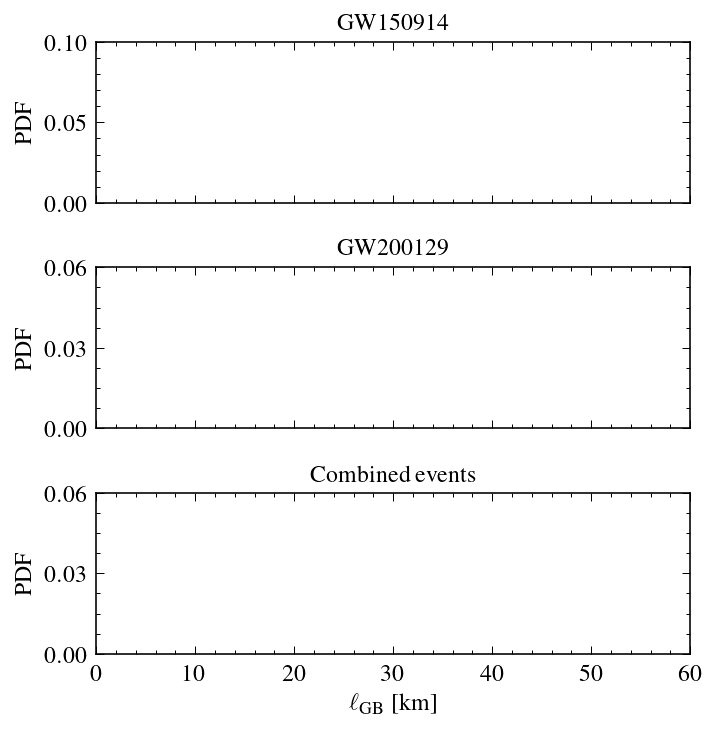

In [37]:
x = [['A', 'A', 'A'],
     ['B', 'B', 'B'],
     ['C', 'C', 'C']]

f, axes = plt.subplot_mosaic(mosaic=x, figsize=(5, 5), gridspec_kw={'hspace': 0.4, 'wspace': 0.6, 'bottom':0.1})
plt.tight_layout()

for k in ('A', 'B', 'C'):
    axes[k].set_xlim(0, 60)
    axes[k].xaxis.set_ticks(np.arange(0, 60+10, 10))
    
for k in ('A', 'B'):
    axes[k].set_xticklabels([]);
    
axes['C'].set_xlabel(r'$\ell_{\rm GB}$ [km]');

# axes['A'].hist(GW150914_dcs_l,      density=True, histtype='step', bins=25, ls='-',  label=r"$j=0$");
# axes['A'].hist(GW150914_spin_dcs_l, density=True, histtype='step', bins=25, ls='--', label=r"$j=0,1$");
axes['A'].set_ylim(0, 0.10);
axes['A'].yaxis.set_ticks([0, 0.05, 0.10]);
axes['A'].set_title("GW150914");
axes['A'].legend(loc='upper right', fontsize=9);
axes['A'].set_ylabel("PDF");

# axes['B'].hist(GW200129_dcs_l,      density=True, histtype='step', bins=25, ls='-',  label=r"$j=0$");
# axes['B'].hist(GW200129_spin_dcs_l, density=True, histtype='step', bins=25, ls='--', label=r"$j=0,1$");
axes['B'].set_ylim(0, 0.06);
axes['B'].yaxis.set_ticks([0, 0.03, 0.06]);
axes['B'].set_title("GW200129");
axes['B'].legend(loc='upper right', fontsize=9);
axes['B'].set_ylabel("PDF");

axes['C'].set_title("Combined events");
axes['C'].xaxis.set_ticks(np.arange(0, 60+10, 10))
axes['C'].set_ylabel("PDF");
# axes['C'].plot(dcs_l_combined, y_dcs_l_combined, '-',  label=r"$j=0$")
# axes['C'].plot(dcs_l_spin_combined, y_dcs_l_spin_combined, '--', label=r"$j=0,1$")
axes['C'].legend(loc='upper right', fontsize=9);
axes['C'].set_ylim(0, 0.06)
axes['C'].yaxis.set_ticks([0, 0.03, 0.06]);

plt.savefig('fig_output/edgb_posteriors_combined.pdf')

/local/tmp/hosilva/ipykernel_1392911/2839656882.py:5: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


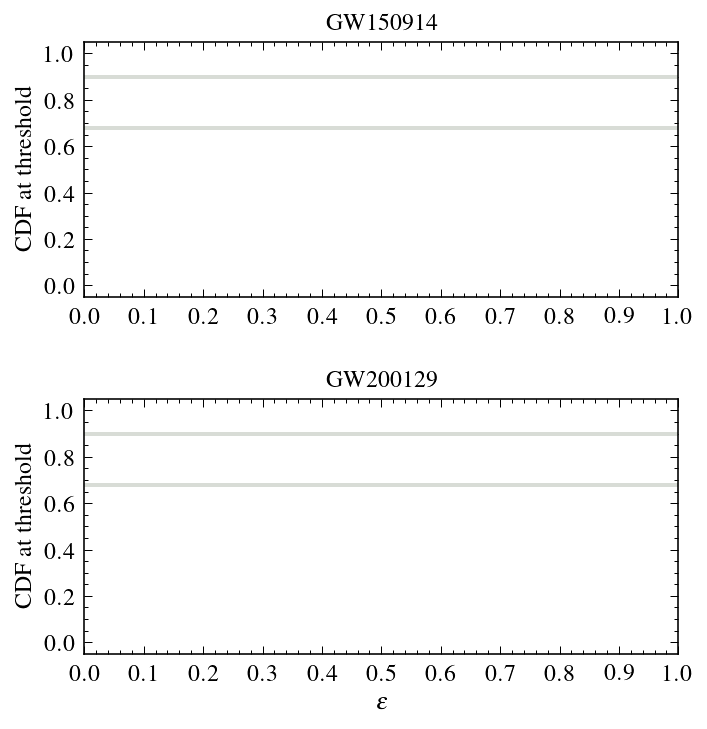

In [38]:
x = [['A', 'A', 'A'],
     ['B', 'B', 'B']]

f, axes = plt.subplot_mosaic(mosaic=x, figsize=(5, 5), gridspec_kw={'hspace': 0.4, 'wspace': 0.5, 'bottom': 0.1})
plt.tight_layout()

for k in ('A', 'B'):
    axes[k].set_xlim(0, 1)
    axes[k].set_ylim(-0.05, 1.05)
    axes[k].xaxis.set_ticks(np.arange(0, 1 + 0.1, 0.1))
    axes[k].axhline(0.90, color='xkcd:light gray', lw=2)
    axes[k].axhline(0.68, color='xkcd:light gray', lw=2)

# -------
# Panel A
# -------
# axes['A'].plot(eps_val, GW150914_m2,      'C0-',  label=r"$m_{2}, \, j=0$")
# axes['A'].plot(eps_val, GW150914_m2_spin, 'C0--', label=r"$m_{2}, \, j=0,1$")
# axes['A'].plot(eps_val, GW150914_mf,      'C1-.', label=r"$M_{f}, \, j=0$")
# axes['A'].plot(eps_val, GW150914_mf_spin, 'C1:',  label=r"$M_{f}, \, j=0,1$")
axes['A'].set_ylabel('CDF at threshold')
axes['A'].set_title("GW150914");
axes['A'].legend(loc='upper left', fontsize=9, facecolor='white');
axes['A'].yaxis.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1.0]);

# -------
# Panel B
# -------
# axes['B'].plot(eps_val, GW200129_m2,      'C0-',  label=r"$m_{2}, \, j=0$")
# axes['B'].plot(eps_val, GW200129_m2_spin, 'C0--', label=r"$m_{2}, \, j=0,1$")
# axes['B'].plot(eps_val, GW200129_mf,      'C1-.', label=r"$M_{f}, \, j=0$")
# axes['B'].plot(eps_val, GW200129_mf_spin, 'C1:',  label=r"$M_{f}, \, j=0,1$")
axes['B'].set_ylabel('CDF at threshold')
axes['B'].set_xlabel(r'$\varepsilon$')
axes['B'].set_title("GW200129");
axes['B'].legend(loc='lower right', fontsize=9);
axes['B'].yaxis.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1.0]);

plt.savefig('fig_output/edgb_cdf_varying_threshold.pdf')

## EFT Cubic